# Demonstration for seismic intensity map generation with LCIS network
## Enable auto-reload of external modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import statements

In [1]:
import glob
import os

import h3
import numpy as np
import obspy
import pandas as pd
from obspy.core.stream import Stream
from obspy.core.trace import Trace
from obspy.geodetics.base import kilometers2degrees
from obspy.taup.tau import TauPyModel
from scipy import signal

from crowdquake.geo import (get_cells_within, load_and_prepare_sensors,
                            select_sensors_by_cells)
from crowdquake.io import import_amplitude_table, import_h3_cell_coverage
from crowdquake.plot import draw_pga_cells_map_v2
from crowdquake.signal import (EQMS_COUNT_TO_G, apply_amplitude, apply_calib,
                               apply_filter, eval_cells_pga, eval_pga,
                               fix_rotation)
from crowdquake.utils import KMA_MMI_STEPS, MMI_LABELS, EventData, intToRoman

import warnings
warnings.filterwarnings(action='ignore')

/opt/anaconda3/envs/intensity-map/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load LCIS network metadata

In [2]:
df, cell_sensors = load_and_prepare_sensors(filepath = "./resources/sensor_list.tsv", resolution = 5)
cell_coverage = import_h3_cell_coverage('./resources/lcis_network_coverage_cells.json')
amp_table = import_amplitude_table('./resources/table.tsv')

## Specify the data to use

In [3]:
filt = (1.5, 25)  # Filter band for LCIS

events = [
    EventData(lat=36.88, lng=127.88, depth=12, magnitude=4.1, max_intensity=5,
              origin_time='2022/10/28 23:27:49',
              basepath='EQ_20221029_082749_kst', # The actual path is ./dataset/EQ_20221029_082749_kst
              distance_threshold=200),
]


## Drawing Seismic Intensity Map with LCIS network
The following code draws seismic intensity map with LCIS network. Output are png images for each configuration. The images are saved in './out/{basepath}' directory. 

Configurations are following:
- raw: data only calibration is applied
- rotated: rotation correction is applied
- filtered: bandpass filter is applied
- amplitude: applied amplitude correction


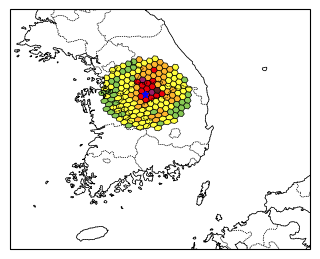

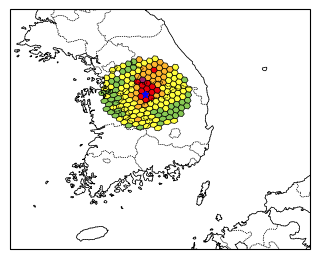

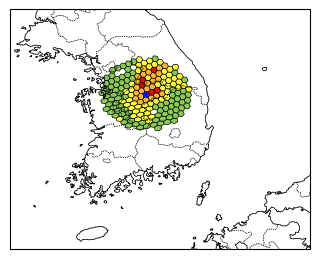

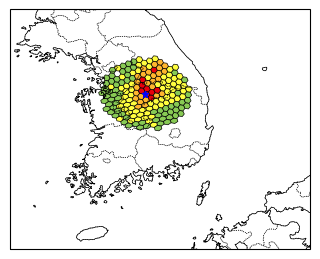

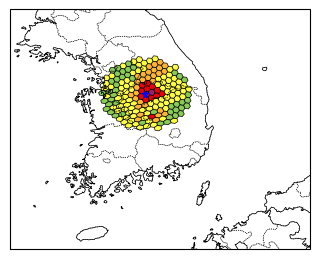

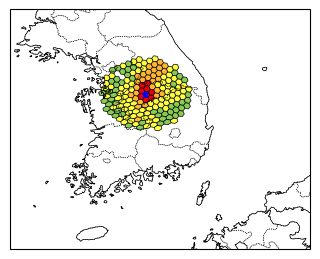

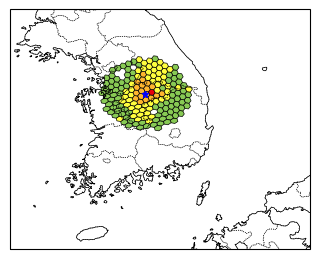

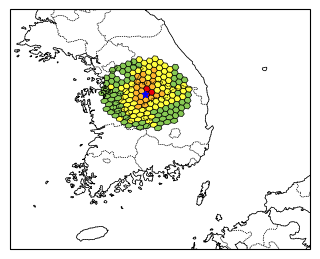

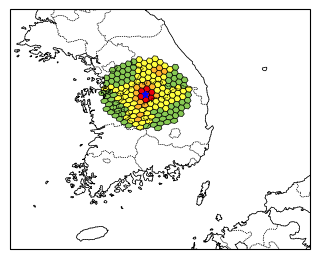

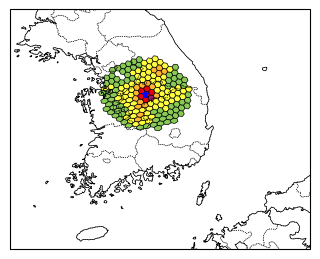

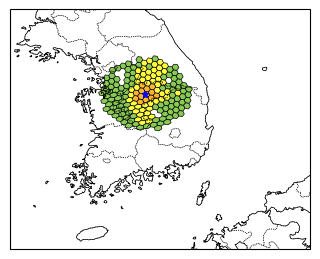

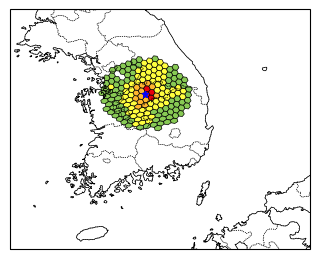

In [4]:
for event in events:
    # Select target cells and sensors for drawing map
    target_cells = get_cells_within(
        event.lat, event.lng, event.pga_eval_distance, cells=cell_coverage)
    target_sensors = select_sensors_by_cells(
        df, target_cells, event.lat, event.lng)

    total = target_sensors.shape[0]
    success, failure = 0, 0

    pgas = []
    # Create output directory
    out_imgs_base = f'./outs/{event.basepath}'
    os.makedirs(out_imgs_base, exist_ok=True)

    for _, d in target_sensors.iterrows():
        try:
            usim = d['usim']
            lat = d['latitude']
            lng = d['longitude']
            distance = d['distance']
            cell = d['cell_5']
            filename = os.path.join('./dataset', event.basepath, f'{usim}.mseed')
            s = obspy.read(filename)
            s = s.slice(event.origin_time - 120, event.origin_time + 120)
            s_calib = apply_calib(s, EQMS_COUNT_TO_G * 100)  # Count to %g, EQMS_COUNT_TO_G is magic number for LCIS
            s_rotated = fix_rotation(s_calib)
            s_filtered = apply_filter(s_rotated, freq=filt)
            s_amp = apply_amplitude(s_filtered, amp_table, usim)
            pga_dict = {
                'usim': usim,
                'lat': lat,
                'lng': lng,
                'cell': cell,
                'raw': eval_pga(s_calib.slice(event.origin_time, event.origin_time + 120), usim, event.depth, distance=distance),
                'rotated': eval_pga(s_rotated.slice(event.origin_time, event.origin_time + 120), usim, event.depth, distance=distance),
                'filtered': eval_pga(s_filtered.slice(event.origin_time, event.origin_time + 120), usim, event.depth, distance=distance),
                'amplitude': eval_pga(s_amp.slice(event.origin_time, event.origin_time + 120), usim, event.depth, distance=distance),
                'available': event.is_usim_available(usim),
                'best': event.is_usim_has_best_condition(usim),
                'distance': distance
            }

            pgas.append(pga_dict)

            success += 1
        except FileNotFoundError:
            failure += 1
            continue
        except AttributeError:
            failure += 1
            continue
        

    df_pgas = pd.DataFrame(pgas)

    # Select only available sensors
    df_pgas_filtered = df_pgas[df_pgas.available == True]

    # Select only available sensors
    df_pgas_best = df_pgas[df_pgas.best == True]

    data_variances = ['raw', 'rotated', 'amplitude', 'filtered']

    for k in data_variances:
        target_dict = df_pgas.groupby('cell')[k].apply(list).to_dict()
        station_pga = df_pgas[['usim', 'lat', 'lng', k, 'distance']]
        station_pga['pga'] = station_pga.pop(k)
        result = eval_cells_pga(target_cells, target_dict,
                                K=1, interpolate_threshold=3)
        fig, ax = draw_pga_cells_map_v2(
            event.lat, event.lng, result, stations_pga=None, distance_threshold=event.distance_threshold,
            figsize=(3, 3))
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        fig.savefig(os.path.join(out_imgs_base, f'{k}.png'), dpi=300, bbox_inches='tight', pad_inches=0)

    # Draw same figure except only with filtered data
    for k in data_variances:
        target_dict = df_pgas_filtered.groupby('cell')[k].apply(list).to_dict()
        station_pga = df_pgas_filtered[['usim', 'lat', 'lng', k, 'distance']]
        station_pga['pga'] = station_pga.pop(k)
        result = eval_cells_pga(target_cells, target_dict,
                                K=1, interpolate_threshold=3)
        fig, ax = draw_pga_cells_map_v2(
            event.lat, event.lng, result, stations_pga=None, distance_threshold=event.distance_threshold,
            figsize=(3, 3))
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        fig.savefig(os.path.join(out_imgs_base, f'{k}_gy.png'), dpi=300, bbox_inches='tight', pad_inches=0)

    # Draw same figure except only with filtered data
    for k in data_variances:
        target_dict = df_pgas_best.groupby('cell')[k].apply(list).to_dict()
        station_pga = df_pgas_best[['usim', 'lat', 'lng', k, 'distance']]
        station_pga['pga'] = station_pga.pop(k)
        result = eval_cells_pga(target_cells, target_dict,
                                K=1, interpolate_threshold=3)
        fig, ax = draw_pga_cells_map_v2(
            event.lat, event.lng, result, stations_pga=None, distance_threshold=event.distance_threshold,
            figsize=(3, 3))
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        fig.savefig(os.path.join(out_imgs_base, f'{k}_best.png'), dpi=300, bbox_inches='tight', pad_inches=0)
